<a href="https://colab.research.google.com/github/Naoki0424/TPS_202110/blob/develop/tensorflow_decision_forests.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environmental Setting

In [ ]:
!pip3 install tensorflow_decision_forests --upgrade

     |████████████████████████████████| 6.3 MB 4.8 MB/s 


In [ ]:
!pip install wandb -qqq

     |████████████████████████████████| 1.7 MB 5.2 MB/s 
     |████████████████████████████████| 97 kB 5.1 MB/s 
     |████████████████████████████████| 180 kB 47.9 MB/s 
     |████████████████████████████████| 139 kB 44.6 MB/s 
     |████████████████████████████████| 63 kB 1.7 MB/s 


# Library Import

In [ ]:
import os
import wandb
import logging
import datetime
import warnings
import gc

import numpy as np
import pandas as pd


from tqdm import tqdm_notebook
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()
%matplotlib inline

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import StratifiedKFold
warnings.filterwarnings('ignore')

import tensorflow_decision_forests as tfdf

sns.set_style('whitegrid')
sns_params = {"palette": sns.color_palette(["#2a9d8f", "#e9c46a"])}

# W&B Setting

In [ ]:
try:
    from kaggle_secrets import UserSecretsClient
    user_secrets = UserSecretsClient()
    secret_value_0 = user_secrets.get_secret("api_key")
    wandb.login(key=secret_value_0)
    anony=None
except:
    anony = "must"
    print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')
    
CONFIG = dict(competition = 'TPSOctober',_wandb_kernel = 'tensorgirl')

If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. 
Get your W&B access token from here: https://wandb.ai/authorize


# Load Data

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [12]:
test= pd.read_csv('drive/My Drive/Colab Notebooks/TPS_202110/data/test.csv', nrows = 1000)
train= pd.read_csv('drive/My Drive/Colab Notebooks/TPS_202110/data/train.csv', nrows = 1000)

In [15]:
test.shape

(1000, 286)

# Observations

There are no missing values in both train ans test dataset.
The train consists of 1000000 data, and the test consists of 500000 data.
The binary features are from f22, f43, f242~f284 and rest of the features are continuous .


Source : https://www.kaggle.com/subinium/tps-oct-simple-eda

In [16]:
train.loc[:, 'f0':'f284'].describe().style.background_gradient(cmap='Pastel1')

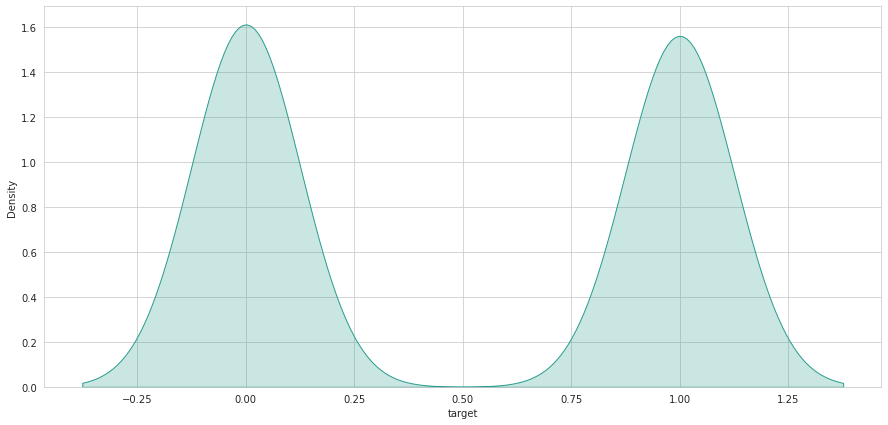

In [17]:
plt.figure(figsize=(15, 7))
sns.kdeplot(train["target"] ,fill=True, color = "#2a9d8f")
